In [1]:
import pickle
from advectionGPdatasets.roundhill import RoundHill,RoundHillModel
from advectionGP.kernels import EQ
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.set_printoptions(precision=1,suppress=True)


In [2]:

#to erase the cache..
#!rm roundhillmodel_cache.pkl
try:
    rhm = pickle.load(open('roundhillmodel_cache.pkl','rb'))
    results = rhm.results
except FileNotFoundError:
    k = EQ(np.array([200,5,5]), 200)
    rhm = RoundHillModel(N_feat=10000,Nparticles=30,k=k)
    results = rhm.compute(30)
    pickle.dump(rhm,open('roundhillmodel_cache.pkl','wb'))

In [3]:
source_grid_pos = rhm.mInfer.getGridCoord([0,0,0])

/home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


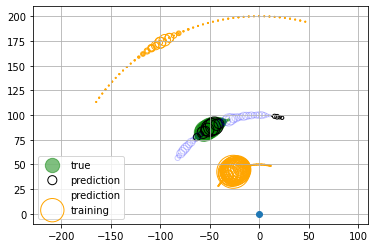

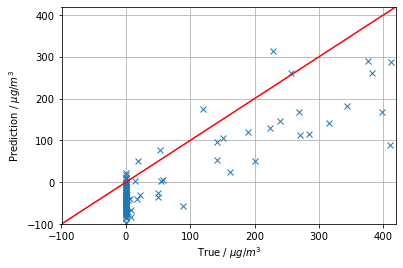

In [8]:
plt.figure()
rhm.plot_test(timepoint=30)
plt.savefig('rhm_plot_test_timepoint30.pdf')
plt.figure()
rhm.scatter_plot_test()
plt.plot([-100,500],[-100,500],'r-')
plt.xlim([-100,420])
plt.ylim([-100,420])
plt.savefig('rhm_scatter_plot_test_timepoint30.pdf')


In [9]:
import GPy
k = GPy.kern.RBF(3,ARD=True,lengthscale=30)
m = GPy.models.GPRegression(rhm.X,rhm.Y[:,None],k)
m.Gaussian_noise = 2.0
#m.optimize()
m.kern.lengthscale

 /home/mike/Documents/Research/GPy/GPy/core/gp.py:85: UserWarning:Your kernel has a different input dimension 3 then the given X dimension 4. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


index,GP_regression.rbf.lengthscale,constraints,priors
[0],30.0,+ve,
[1],30.0,+ve,
[2],30.0,+ve,


 /home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning:invalid value encountered in sqrt
 /home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning:invalid value encountered in sqrt


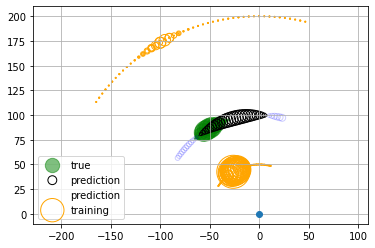

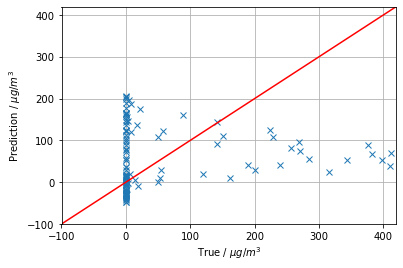

In [11]:
GPpreds, GPvars = m.predict(rhm.Xtest)
plt.figure()
rhm.plot_test(GPpreds,30)
plt.savefig('rhm_GP_plot_test_timepoint30.pdf')
plt.figure()
rhm.scatter_plot_test(GPpreds)
plt.plot([-100,500],[-100,500],'r-')
plt.xlim([-100,420])
plt.ylim([-100,420])

plt.savefig('rhm_GP_scatter_plot_test_timepoint30.pdf')


In [12]:
rhm.compute_RMSE()

847.2876380867098

In [13]:
def MAE(a):
    return np.mean(np.abs(a))
def RMSE(a):
    return np.sqrt(np.mean(a**2))
def MSE(a):
    return np.mean(a**2)

print(" Time     GP   Adjoint")
for t in [30,180,600]:
    keep = rhm.Xtest[:,1]==t
    thresholdGPpreds = GPpreds.copy()
    thresholdGPpreds[thresholdGPpreds<0]=0
    thresholdpreds = rhm.results['testconc']['mean'].copy()
    thresholdpreds[thresholdpreds<0]=0
    print("%5d: %6.0f %6.0f" % (t,MSE(rhm.Ytest[keep]-thresholdGPpreds[keep,0]),MSE(rhm.Ytest[keep]-thresholdpreds[keep])))

 Time     GP   Adjoint
   30:  21385   5533
  180:  12968   1926
  600:   8490   3131


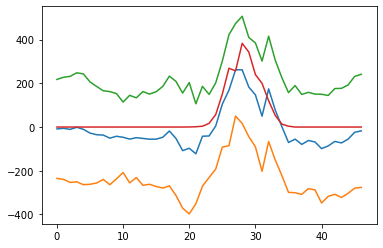

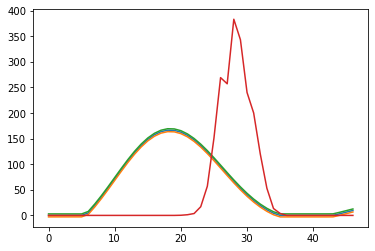

In [14]:
keep = rhm.Xtest[:,1]==180
plt.plot(results['testconc']['mean'][keep]);
plt.plot(results['testconc']['mean'][keep]-2*np.sqrt(results['testconc']['var'][keep]));
plt.plot(results['testconc']['mean'][keep]+2*np.sqrt(results['testconc']['var'][keep]));
plt.plot(rhm.Ytest[keep])
plt.figure()
plt.savefig('rhm_plot_pred_slice_time180.pdf')
plt.plot(thresholdGPpreds[keep])
plt.plot(thresholdGPpreds[keep]-2*np.sqrt(GPvars[keep]))
plt.plot(thresholdGPpreds[keep]+2*np.sqrt(GPvars[keep]))
plt.plot(rhm.Ytest[keep])
plt.savefig('rhm_plot_GP_pred_slice_time180.pdf')

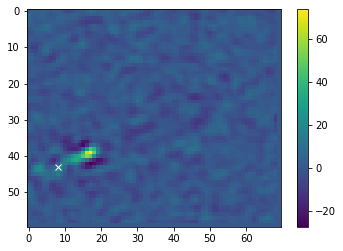

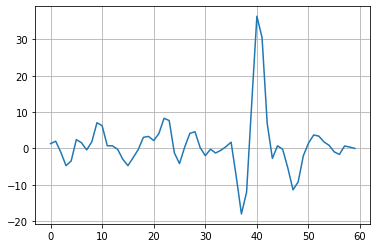

In [16]:
plt.imshow(results['sources']['mean'][30,:,:])
plt.colorbar()
plt.plot(source_grid_pos[2],source_grid_pos[1],'wx')
plt.savefig('rhm_source_plot.pdf')
plt.figure()
plt.plot(results['sources']['mean'][30,:,14])
plt.grid()
plt.savefig('rhm_source_plot_slice.pdf')

# Non-negative

In [17]:
from advectionGP.kernels import meshgridndim
from advectionGP.constraints import NonNegConstraint

top,bottom = np.array([-60., -70.,  -30.]), np.array([200.,  68, 60])
Xnonneg = meshgridndim([top,bottom],17,True)
nnc = NonNegConstraint(rhm.mInfer,rhm.Y,Xnonneg,thinning=10,jitter=1e-4,verbose=True,burnin=50,usecaching=False)#,startpointnormalised=True)
samps = nnc.sample(20) #spare start point makes it overly smooth etc

Computing mean and covariance of Z distribution
Computing SS...
Inverting SS...
Computing meanZ
Done
Instantiating Truncated MVN object
Computing Cholesky...
Inverting Cholesky...
Instantiation Complete
Sampling...
Computing inverse, for conditional distributions.
Sampling
Starting sampling loop
  249/  250 [samples]


In [18]:
import pickle
pickle.dump(samps,open('nnsamps.pkl','wb'))

In [19]:
#dill.dump([nnc,samps,Xnonneg,top,bottom],open('nonneg.pkl','wb'))

In [20]:
planes = np.array([phi for phi in rhm.mInfer.kernel.getPhi(Xnonneg.T)])
np.all(planes.T @ samps.T>0)

True

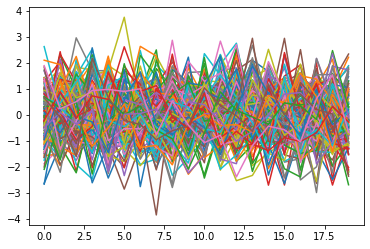

In [21]:
plt.plot(samps[:,::60]-np.mean(samps[:,::60],0));

In [22]:
sourcesNoNeg = np.array([rhm.mInfer.computeSourceFromPhiInterpolated(z) for z in samps])
import pickle
pickle.dump(sourcesNoNeg,open('nn_sources.pkl','wb'))

cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...
cache miss, computing source from phi...


In [23]:
particles = rhm.mInfer.genParticlesFromObservations(50,rhm.testsensors)
meantestconc,vartestconc,testconc = rhm.mInfer.computeConcentration(
            particles=particles,Zs=samps,interpolateSource=True)

pickle.dump([meantestconc,vartestconc,testconc],open('nn_conc','wb'))

Initialising particles...
Particle shape:
(50, 117, 3)
Diffusing particles...


In [24]:
testconc.shape

(20, 117)

In [25]:
rhm.compute_RMSE()

847.2876380867098

In [26]:
rhm.compute_RMSE(meantestconc)

5954.365911673481

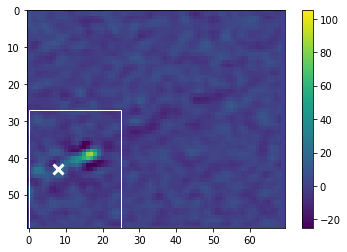

In [61]:

gridCoordsXnonneg = rhm.mInfer.getGridCoord(Xnonneg)
gridEdgeNonNeg = np.array([np.min(gridCoordsXnonneg,0),np.max(gridCoordsXnonneg,0)]) #rhm.mInfer.getGridCoord([top,bottom])
plt.imshow(rhm.results['sources']['mean'][11,:,:])
plt.colorbar()
plt.plot(source_grid_pos[2],source_grid_pos[1],'xw',markersize=10,mew=3)
#plt.plot(gridCoordsXnonneg[:,2],gridCoordsXnonneg[:,1],'.b',markersize=1)
#plt.clim([0,40])
plt.vlines(gridEdgeNonNeg[:,2],gridEdgeNonNeg[0,1],gridEdgeNonNeg[1,1],'w',lw=1)
plt.hlines(gridEdgeNonNeg[:,1],gridEdgeNonNeg[0,2],gridEdgeNonNeg[1,2],'w',lw=1)
plt.ylim([59,0])
plt.clim([-25,105])
plt.savefig('rhm_source_plot_again.pdf')

 /home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning:invalid value encountered in sqrt


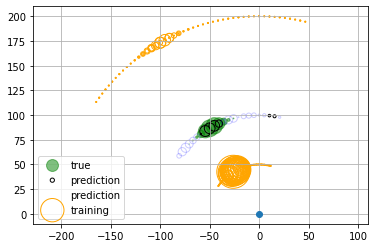

In [30]:
rhm.plot_test()
plt.savefig('rhm_plot_test_normal.pdf')

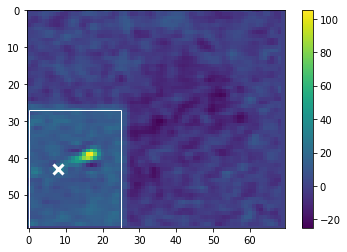

In [60]:

gridCoordsXnonneg = rhm.mInfer.getGridCoord(Xnonneg)
gridEdgeNonNeg = np.array([np.min(gridCoordsXnonneg,0),np.max(gridCoordsXnonneg,0)]) #rhm.mInfer.getGridCoord([top,bottom])
plt.imshow(np.mean(sourcesNoNeg,0)[11,:,:])
plt.colorbar()
plt.plot(source_grid_pos[2],source_grid_pos[1],'xw',markersize=10,mew=3)
#plt.plot(gridCoordsXnonneg[:,2],gridCoordsXnonneg[:,1],'.b',markersize=1)
#plt.clim([0,40])
plt.vlines(gridEdgeNonNeg[:,2],gridEdgeNonNeg[0,1],gridEdgeNonNeg[1,1],'w',lw=1)
plt.hlines(gridEdgeNonNeg[:,1],gridEdgeNonNeg[0,2],gridEdgeNonNeg[1,2],'w',lw=1)
plt.ylim([59,0])
plt.clim([-25,105])
plt.savefig('rhm_source_plot_NONEG.pdf')

(27, 59)

 <ipython-input-59-81e06c7007ac>:8: MatplotlibDeprecationWarning:The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
 <ipython-input-59-81e06c7007ac>:8: MatplotlibDeprecationWarning:The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.


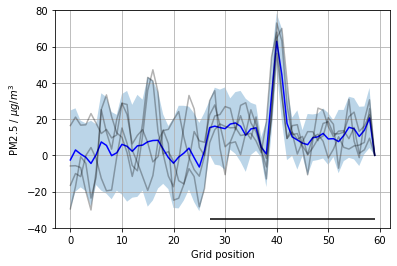

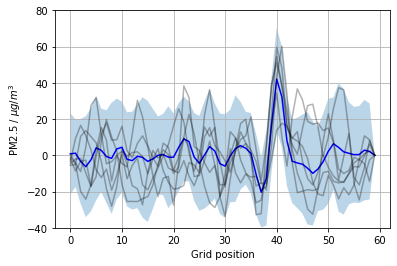

In [59]:
#plot slices
for fn,data in zip(['nonneg','normal'],[sourcesNoNeg,rhm.results['sources']['all']]):
    plt.figure()
    s = np.std(data[:,11,:,14],0)
    m = np.mean(data[:,11,:,14],0)
    plt.plot(np.arange(60),m,'b');
    plt.plot(np.arange(60),data[::5,11,:,14].T,'k',alpha=0.3);
    plt.fill_between(np.arange(60),m-1.96*s,m+1.96*s,'b',alpha=0.3);
    plt.xlabel('Grid position')
    plt.ylabel('PM2.5 / $\mu g/m^3$')
    plt.ylim([-40,80])
    plt.grid()
    if fn=='nonneg':
        plt.hlines(-35,gridEdgeNonNeg[0,1],gridEdgeNonNeg[1,1])
    plt.savefig('slice'+fn+'.pdf')

 /home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning:invalid value encountered in sqrt
 /home/mike/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:885: RuntimeWarning:invalid value encountered in sqrt


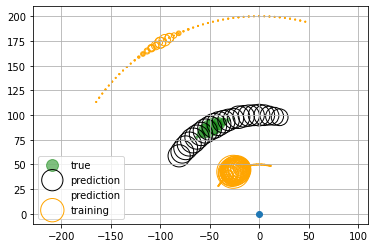

In [29]:
rhm.plot_test(meantestconc)
plt.savefig('rhm_plot_test_noneg.pdf')

# Experimental: Marginal Likelihood

In [4]:
rhm.mInfer.coords.T.shape

(70, 60, 100, 3)

In [11]:
meanZ, covZ=rhm.mInfer.computeZDistribution(rhm.Y)

Computing SS...
Inverting SS...
Computing meanZ
Done


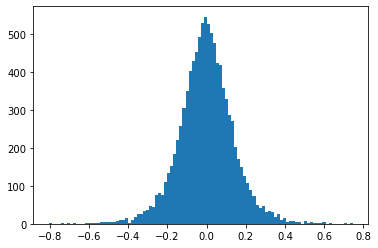

In [20]:
plt.hist(meanZ,100);

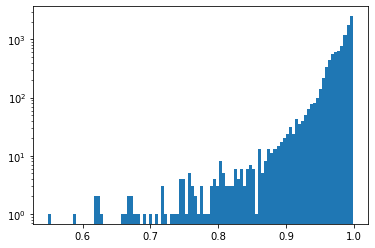

In [16]:
plt.hist(np.diag(covZ),100,log=True);

In [31]:
np.max(mat)

0.2460316096952032

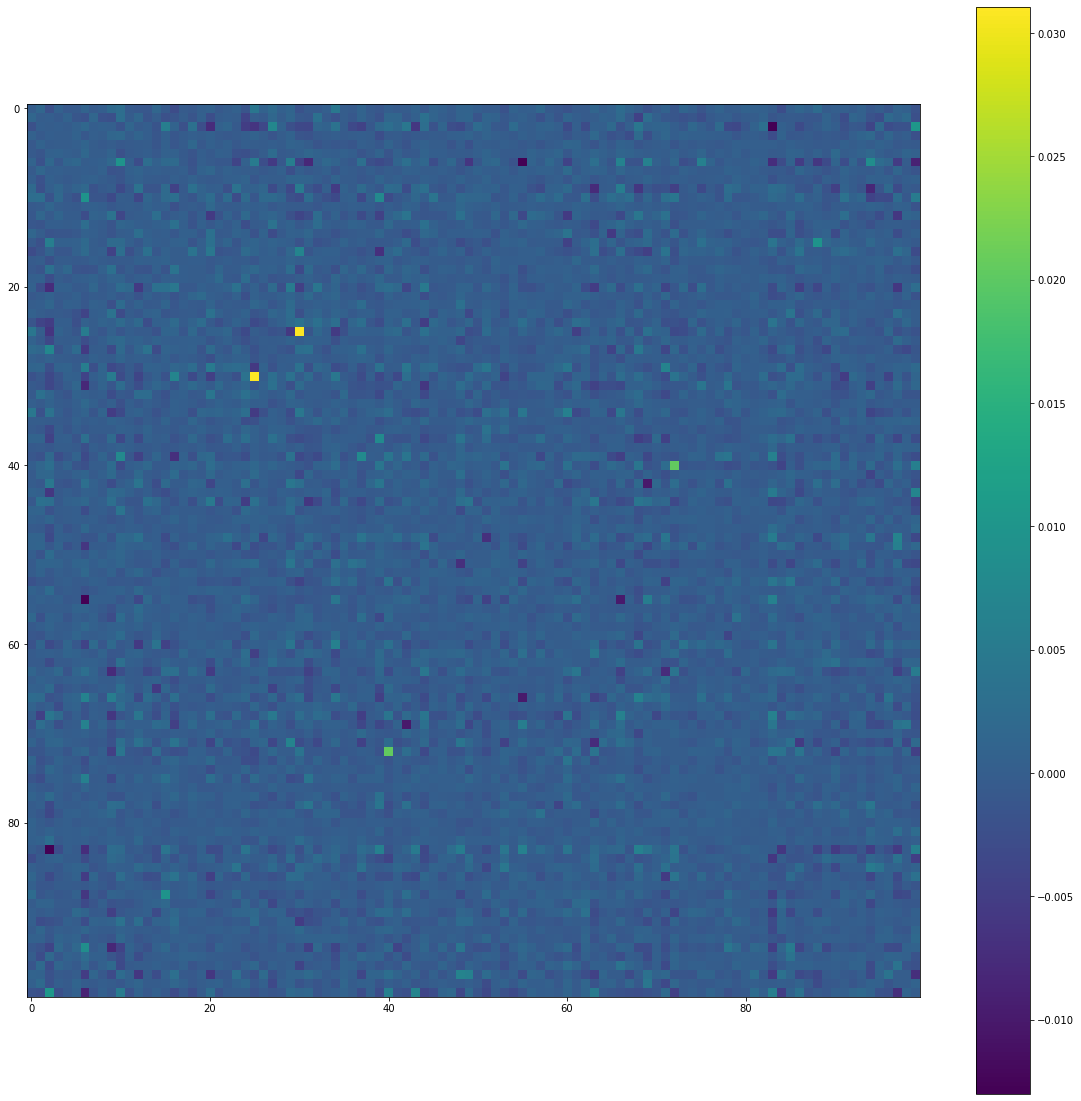

In [30]:
plt.figure(figsize=[20,20])
mat = covZ-np.diag(np.diag(covZ))
plt.imshow(((mat[:100,:100])))
plt.colorbar()

In [16]:
from scipy.stats import multivariate_normal as mvn

for ls in [6,7]:
    k = EQ(np.array([200,ls,ls]), 200)
    rhmTest = RoundHillModel(N_feat=7000,Nparticles=10,k=k)
    results = rhmTest.compute(0)
    cov = rhmTest.mInfer.X.T @ rhmTest.mInfer.X + rhmTest.mInfer.noiseSD**2 * np.eye(rhmTest.mInfer.X.shape[1])
    print(ls,mvn.logpdf(rhmTest.Y,cov=cov))

Initialising particles...
Diffusing particles...


KeyboardInterrupt: 